# BART BMM: 2D Example
### Author: John Yannotty
#### Date: 04/01/23

This example demonstrates the BART-BMM model on a 2-dimensional example. For this example, assume the true system is defined by $$f_\dagger(x) = \sin(x_1) + \cos(x_2),$$ over the domain $(x_1,x_2) \in [-\pi,\pi]\times [-\pi,\pi]$.  Furthermore, consider a model set which defines $K$ simulators under consideration in terms of Taylor series expanions of $\sin(x_1)$ and $\cos(x_2)$. This example considers mixing two simulators, defined by $h_1(x)$ and $h_2(x)$ as shown below:      

\begin{align}
    h_1(x) &= \sum_{j=0}^7 \frac{s^{(j)}(x_1)}{j!}(x_1-\pi)^j + \sum_{k=0}^{10} \frac{c^{(k)}(x_2)}{k!}(x_2-\pi)^k  \\[8 pt]  
    h_2(x) &= \sum_{j=0}^{13} \frac{s^{(j)}(x_1)}{j!}(x_1+\pi)^j + \sum_{k=0}^6 \frac{c^{(k)}(x_2)}{k!}(x_2+\pi)^k.
\end{align}

where $x = (x_1,x_2)$, $s^{(j)}(x_1)$ denotes the jth derivative of $\sin(x_1)$, and $c^{(k)}(x_1)$ denotes the kth derivative of $\cos(x_2)$. The simulator, $h_1(x)$ involves Taylor series expansions of $\sin(x_1)$ and $\cos(x_2)$ about $\pi$. Meanwhile, $h_2(x)$ is constructed using two Taylor series expansions about $-\pi$. 

In [64]:
# Basic imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.graph_objects as go
import importlib
sys.path.append('../../../../Taweret')


In [2]:
# Taweret imports
import Taweret.models.polynomial_models 
from Taweret.models.polynomial_models import sin_exp, cos_exp, sin_cos_exp
from Taweret.mix.trees import Trees


Installation Failed


In [3]:
# Import lib for testing
importlib.reload(Taweret.models.polynomial_models)
import Taweret.models.polynomial_models 
from Taweret.models.polynomial_models import sin_exp, cos_exp, sin_cos_exp

importlib.reload(Taweret.mix.trees)
import Taweret.mix.trees
from Taweret.mix.trees import Trees


## Training Data

Prior to mixing, we can generate training data over a two-dimensional grid. This is done by first generating a set of training inputs using the grid_2d_design(...) function. These training points are passed through the true function of $f_\dagger(x) = \sin(x_1) + \cos(x_2)$. Then random noise is added to simulate observational data. Below generates data from 80 training points, though one can easily use a smaller or larger training set.

In [7]:
## Functions for design points 
# n1 = number of bins in the x1 dimension
# n2 = number of bins in the x2 dimension
# n = n1*n2 is the total training size
def grid_2d_design(n1,n2, xmin = [-1,-1], xmax = [1,1]):
  # Generate n uniform rvs
  n = n1*n2
  ux = np.random.uniform(0,1,n)
  uy = np.random.uniform(0,1,n)

  # Dimensions for each rectangle
  x1_len = (xmax[0] - xmin[0])/n1
  x2_len = (xmax[1] - xmin[1])/n2
  xgrid = [[x, y] for x in range(n1) for y in range(n2)]
  xgrid = np.array(xgrid).transpose()

  # Get points
  x1 = ux*x1_len + x1_len*xgrid[0] + xmin[0]
  x2 = uy*x2_len + x2_len*xgrid[1] + xmin[1]

  # Join data
  xdata = np.array([x1,x2]).transpose()
  return xdata

In [8]:
# Generate Data
n_train = 80
x_train = grid_2d_design(10,8,[-np.pi,-np.pi],[np.pi,np.pi])
f0_train = np.sin(x_train.transpose()[0]) + np.cos(x_train.transpose()[1])
y_train = f0_train + np.random.normal(0,0.1,n_train)


The design of the experiment is shown below. Clearly the training points are spread out across the entire domain.

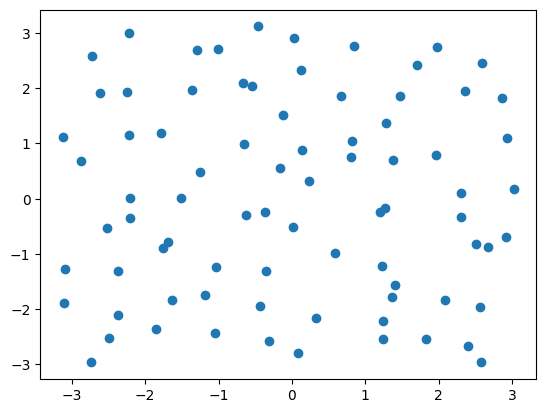

In [6]:
# Visualize the 
plt.scatter(x_train.transpose()[0],x_train.transpose()[1])
plt.show()

Next the true system is shown below. For this plot, we can evaluate $f_\dagger(x)$ over a dense grid.

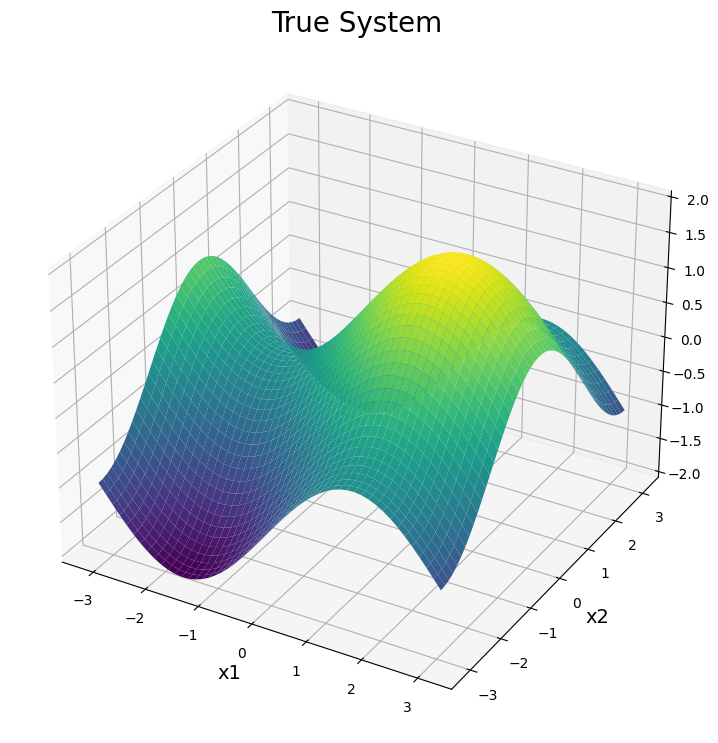

In [61]:
# Plot the surfaces
x1_test = np.outer(np.linspace(-np.pi, np.pi, 50), np.ones(50))
x2_test = x1_test.copy().transpose()
f0_test = (np.sin(x1_test) + np.cos(x2_test))
x_test = np.array([x1_test.reshape(x1_test.size,),x2_test.reshape(x1_test.size,)]).transpose()

# Define color map
cmap = plt.get_cmap('viridis')

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x1_test, x2_test, f0_test, cmap = cmap, vmin = -2, vmax = 2)
plt.title("True System", size = 20)
plt.xlabel("x1", size = 14)
plt.ylabel("x2", size = 14)
ax.set_zlim([-2,2])

# show plot
plt.show()

Now we can view the two simulators we wish to mix. The first simulator is comprised of two Taylor series expansions centeres about $\pi$, hence it provides higher fidelity predictions in the upper right corner of the domain. The second simulator is comprised of two Taylor series expansions centeres about $-\pi$. Additionally, its Taylor series expansion of $\sin(x)$ is a high-fidelity approxmiation across the entire interval of $[\pi,\pi]$. Hence $h_2(x)$ provides higher fidelity predictions in the bottom half of the domain. 

The surfaces produced by each simulator are shown below.

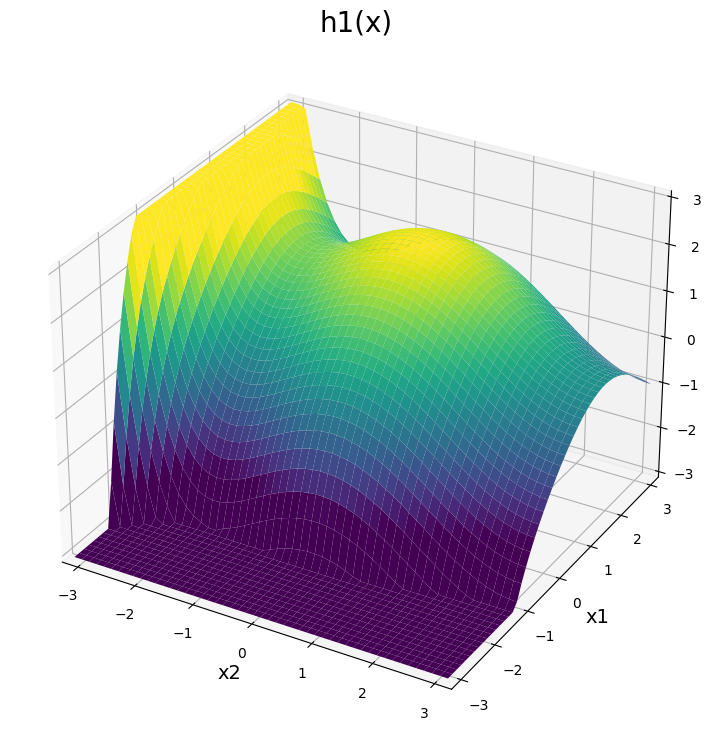

In [60]:
# Plot the first simulator
sin7 = sin_exp(7,np.pi)
cos10 = cos_exp(10,np.pi)

h1_sin = sin7.evaluate(x1_test.transpose()[0])[0]
h1_cos = cos10.evaluate(x1_test.transpose()[0])[0]

h1_sin_grid = np.outer(h1_sin, np.ones(50))
h1_cos_grid = np.outer(h1_cos, np.ones(50)).transpose()

h1_test = h1_sin_grid + h1_cos_grid

# Subset the data for the plot (only for visualization)
h1_test_filter = h1_test
for i in range(50):
    h1_test_filter[i][np.where(h1_test_filter[i]>3)] = 3.05
    h1_test_filter[i][np.where(h1_test_filter[i]<-3)] = -3.05
    
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x2_test, x1_test, h1_test_filter, cmap = cmap, vmin = -2, vmax = 2)
ax.set_zlim([-3,3])
ax.set_xlim([-np.pi,np.pi])
ax.set_ylim([-np.pi,np.pi])
plt.title("h1(x)", size = 20)
plt.xlabel("x2", size = 14)
plt.ylabel("x1", size = 14)

# show plot
plt.show()

In [8]:
#fig = go.Figure(data=[go.Surface(z=h1_test, x=x1_test.transpose()[0], y=x1_test.transpose()[0])])
#fig.update_layout(title='Mt Bruno Elevation', autosize=False,width=500, height=500)
#fig.show()

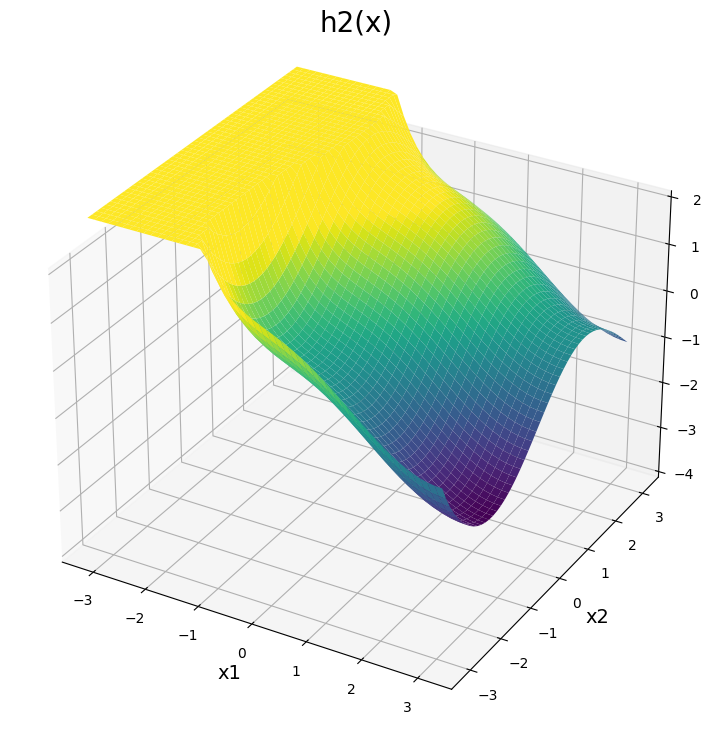

In [59]:
# Plot the second simulator
sin13 = sin_exp(13,np.pi)
cos6 = cos_exp(6,np.pi)

h2_sin = sin13.evaluate(x1_test.transpose()[0])[0]
h2_cos = cos6.evaluate(x1_test.transpose()[0])[0]

h2_sin_grid = np.outer(h2_sin, np.ones(50))
h2_cos_grid = np.outer(h2_cos, np.ones(50)).transpose()

h2_test = h2_sin_grid + h2_cos_grid

# Subset the data for the plot (only for visualization)
h2_test_filter = h2_test
for i in range(50):
    h2_test_filter[i][np.where(h2_test_filter[i]>3)] = 3.05
    h2_test_filter[i][np.where(h2_test_filter[i]<-3)] = -3.05


# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.set_zlim([-4,2])
ax.plot_surface(x2_test, x1_test, h2_test,cmap = cmap, vmin = -2, vmax = 2)
plt.title("h2(x)", size = 20)
plt.xlabel("x1", size = 14)
plt.ylabel("x2", size = 14)

# show plot
plt.show()

In [24]:
# Fit the BMM model
h1 = sin_cos_exp(7,10,np.pi,np.pi)
h2 = sin_cos_exp(13,6,-np.pi,-np.pi)
model_dict = {'model1':h1, 'model2':h2}
#h1.evaluate([[np.pi,np.pi],[-np.pi,0]])[0]


## The BART BMM Model

This section demonstrates how to train the BMM model for the 2D example. 

In [39]:
# Fit the BMM Model
# Initialize the Trees class instance
mix = Trees(model_dict = model_dict, local_openbt_path = "/home/johnyannotty/Documents/openbt/src")

# Set prior information
mix.set_prior(k=1.25,ntree=30,overallnu=5,overallsd=0.005,inform_prior=False)

# Train the model
fit = mix.train(X=x_train, y=y_train, ndpost = 10000, nadapt = 2000, nskip = 2000, adaptevery = 500, minnumbot = 4)


Results stored in temporary path: /tmp/openbtpy_3j7pdsru
Running model...


In [40]:
# Get predictions
ppost, pmean, pci, pstd = mix.predict(X = x_test, ci = 0.95)
wpost, wmean, wci, wstd = mix.predict_weights(X = x_test, ci = 0.95)


The resulting predicted system is shown below. The prediction is very accurate across the domain and is able to recover the peaks and valleys of the true function. The prediction struggles along the edges when one or both simulators diverge. For instance, a poor prediction is seen in the top left corner of the domain where both simulators are inaccurate and minimal training data is present. 

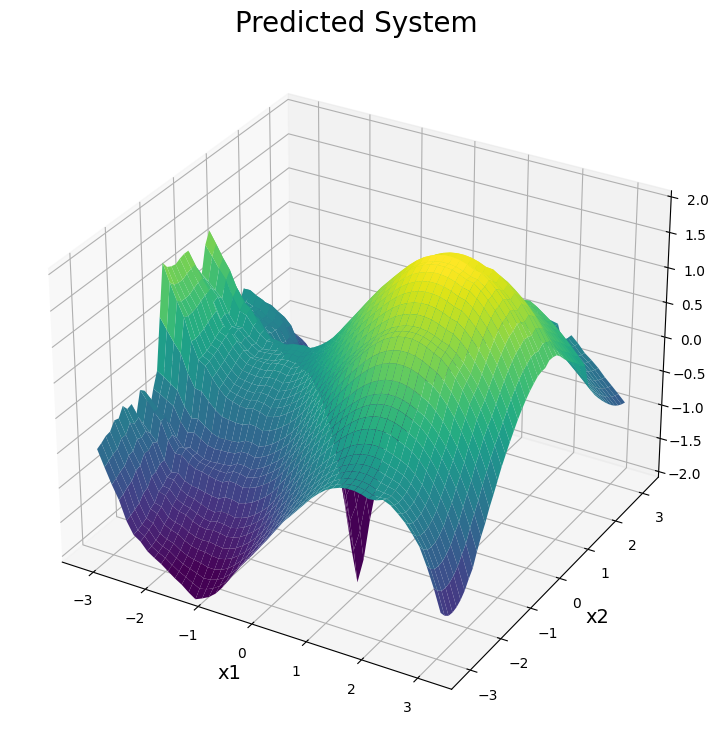

In [63]:
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.plot_surface(x1_test, x2_test, pmean.reshape(x1_test.shape), cmap = cmap, vmin = -2, vmax = 2)
plt.title("Predicted System", size = 20)
plt.xlabel("x1", size = 14)
plt.ylabel("x2", size = 14)
ax.set_zlim([-2,2])

# show plot
plt.show()

In [44]:
# Get the training error
np.sqrt(np.mean((pmean - f0_test.reshape(pmean.shape))**2))

0.22860946674034263

The mean weight functions for both simulators are shown below. Both weight functions take higher values when the corresponding simulator provides a higher-fidelity approximation. Note, the patterns in the weight functions match the intuition about where each simulator is locally accurate or inaccurate as previously described. 

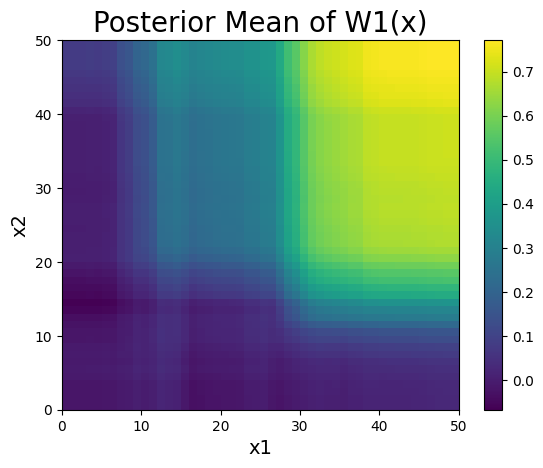

In [122]:
#sb.heatmap(wmean)
w1 = wmean.transpose()[0]
w2 = wmean.transpose()[1]

w1_mean = wmean.transpose()[0]
w1_mean = w1_mean.reshape(x1_test.shape)

plt.pcolormesh(w1_mean)
plt.colorbar()
plt.title("Posterior Mean of W1(x)", size = 20)
plt.xlabel("x1", size = 14)
plt.ylabel("x2", size = 14)
plt.show()




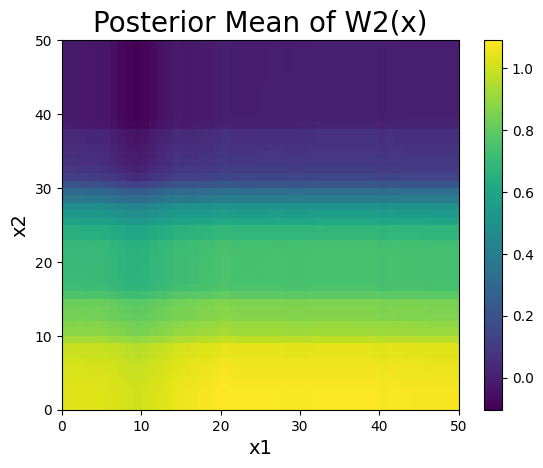

In [121]:
w2_mean = wmean.transpose()[1]
w2_mean
w2_mean = w2_mean.reshape(x1_test.shape).transpose()

plt.pcolormesh(w2_mean)
plt.colorbar()
plt.title("Posterior Mean of W2(x)", size = 20)
plt.xlabel("x1", size = 14)
plt.ylabel("x2", size = 14)
plt.show()


Finally, the posterior distribution of the error variance is shown below. The resulting posterior concentrates about the true value of 0.1. This means, the error standard deviation is accurately recovered with small uncertainty.

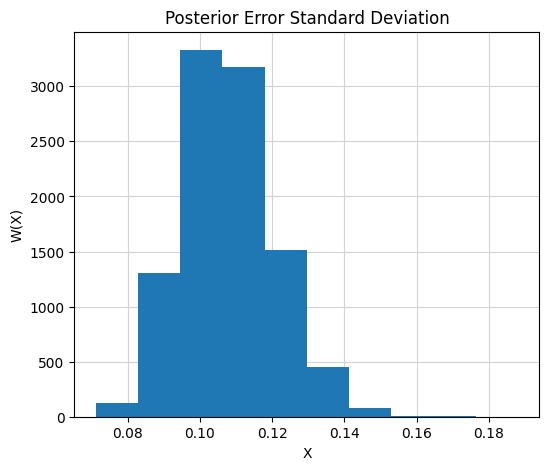

In [45]:
# Plot the posterior of the error standard deviation
mix.plot_sigma()
